# GDR RSD School - Hackathon - Python load injection

This notebook presents how to use a home-made python script to inject load in the system.

We run **1 instance** of the python script for **each CoAP server** available (M3 sensor).

The script is extremely simple:
```python
while True:
    do_coap_request(sensor)
    time.sleep(sleep_interval)
```

These 2 parameters dictate the execution:

    - duration: describes for how many seconds the script will run
    - sleep_interval: the interval between requests, smaller sleep intervals mean higher load

## Parameters of this notebook

This allows you to modify them through papermill.

In [1]:
%cd ../../
%pwd

/home/jovyan


'/home/jovyan'

In [2]:
import enoslib as en

import logging
import sys
import datetime
import pathlib
import uuid

The Vagrant executable cannot be found. Please check if it is in the system path.


Note: Openstack clients not installed


---
This cell presents all the paramters used in this notebook that can be modified through papermill.

**Important**: set the site and IPv6 network assigned to you in [rsd2021hack.csv](../../setup/rsd2021hack.csv)

In [3]:
#parameters to this notebook
output_dir = "data/raw/%s/%s" % (str(datetime.date.today()), str(uuid.uuid4())) # location for output files
br_image="data/firmware/custom/contikimac/border-router.iotlab-m3"      # border router firmware
er_image="data/firmware/custom/contikimac/er-example-server.iotlab-m3"  # sensor/coap server firmware
iotlab_site="grenoble" # IoT-LAB site
iotlab_nodes=4         # number of nodes in IoT-LAB platform, 1 border router, N - 1 sensors
iotlab_ipv6_net="2001:660:5307:3130::"  # IPv6 subnet, depends on the site
job_name="hackathon"   # job_name to submit to platforms
sleep_interval=5       # interval between requests
duration=300           # duration of load injection
free_resources=True    # destroy job in testbeds at the end
g5k_nodes=1

## Initialization

Some information about this experiment

In [4]:
# creating output folder
pathlib.Path(output_dir).mkdir(exist_ok=True, parents=True)
print("Starting new experiment %s" % (output_dir))

Starting new experiment data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f


---
Configuring logging: save DEBUG to a file and INFO to stdout.

In [5]:
log = logging.getLogger()
log.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler("%s/debug.log" % (output_dir), 'a')
fileHandler.setLevel(logging.DEBUG)
fileHandler.setFormatter(formatter)
log.addHandler(fileHandler)

cformat = logging.Formatter("[%(levelname)8s] : %(message)s")
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(cformat)
consoleHandler.setLevel(logging.INFO)
log.addHandler(consoleHandler)

## IoT-LAB

### Describing the resources

Get list of IoT-LAB nodes available

In [6]:
import os

iotlab_nodes_list = []

with open(os.path.expanduser("~/.iotlab_nodes"), "r") as f:
    iotlab_nodes_list = f.read().splitlines()

print("Available nodes: %s" % str(iotlab_nodes_list))
br_nodes = iotlab_nodes_list[0:1] # 1 border router
coap_nodes = iotlab_nodes_list[1:iotlab_nodes] # n - 1 CoAP servers

print("Border-router: %s" % str(br_nodes))
print("CoAP servers: %s" % str(coap_nodes))

Available nodes: ['m3-15.grenoble.iot-lab.info', 'm3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info', 'm3-19.grenoble.iot-lab.info']
Border-router: ['m3-15.grenoble.iot-lab.info']
CoAP servers: ['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info']


Describing resources usinb EnOSlib.

In [7]:
iotlab_dict = {
    "job_name": job_name,
    "walltime": "02:00",       # duration of the experiment: e.g. 1 hour
    "resources":
    {"machines": [
        {
            "roles": ["coap-server"],      # user-defined role for these nodes: CoAP servers
            "hostname": coap_nodes,            
            "image": er_image,             # initial image to be installed on the nodes
            "profile": "energy",           # monitoring profile, defined below
        },
        {
            "roles": ["border-router"],   # user-defined string, 1 border-router in our example
            "hostname": br_nodes,                        
            "image": br_image,
            "profile": "energy",
        },
    ]},
    "monitoring": {
        "profiles": [{
            "name": "energy",           # More details: https://www.iot-lab.info/legacy/tutorials/monitoring-consumption-m3/index.html
            "archi": "m3",
            "consumption": {
                "current": True,
                "power": True,
                "voltage": True,
                "period": 8244,         # interval between measurements in us
                "average": 4,
            },
        }]
    }
}

# creating the object for our reservation
# the nodes aren't avaible until you call init() on these objects
iotlab_conf = en.IotlabConf.from_dictionary(iotlab_dict)
iotlab_provider = en.Iotlab(iotlab_conf)
iotlab_conf

Conf@0x7fbb5c16c0a0
{
    "job_name": "hackathon",
    "walltime": "02:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "coap-server"
                ],
                "image": "data/firmware/custom/contikimac/er-example-server.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-16.grenoble.iot-lab.info",
                    "m3-17.grenoble.iot-lab.info",
                    "m3-18.grenoble.iot-lab.info"
                ]
            },
            {
                "roles": [
                    "border-router"
                ],
                "image": "data/firmware/custom/contikimac/border-router.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-15.grenoble.iot-lab.info"
                ]
            }
        ],
        "networks": []
    },
    "monitoring": {
        "profiles": [
            {
                "name": "energy",
                "archi": "m3",
                "consumption": {
                    "current": true,
                    "power": true,
                    "voltage": true,
                    "period": 8244,
                    "average": 4
                }
            }
        ]
    }
}

### Reserving the resources

In [8]:
iotlab_roles, iotlab_networks = iotlab_provider.init()
iotlab_roles

[    INFO] : Submitting profile: energy, got {'nodearch': 'm3', 'power': 'dc', 'consumption': {'period': 8244, 'average': 4, 'current': True, 'voltage': True, 'power': True}, 'profilename': 'energy'}
[    INFO] : Submitting FIT/IoT-LAB: job id: hackathon, duration: 02:00, resources: [{'type': 'physical', 'nodes': ['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info'], 'firmware': None, 'profile': 'energy', 'associations': {}}, {'type': 'physical', 'nodes': ['m3-15.grenoble.iot-lab.info'], 'firmware': None, 'profile': 'energy', 'associations': {}}]
[    INFO] : Job submitted: 277268
[    INFO] : Waiting for job id (277268) to be in running state
[    INFO] : Job id (277268) is running
[    INFO] : Finished reserving nodes: hosts [], sensors [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/custom/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], addre

{'coap-server': [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/custom/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-17.grenoble.iot-lab.info, site=grenoble, uid=a172)>image=data/firmware/custom/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-18.grenoble.iot-lab.info, site=grenoble, uid=b679)>image=data/firmware/custom/contikimac/er-example-server.iotlab-m3)>], 'border-router': [<IotlabSensor(roles=['border-router'], address=m3-15.grenoble.iot-lab.info, site=grenoble, uid=c280)>image=data/firmware/custom/contikimac/border-router.iotlab-m3)>]}

### Setting up the IPv6 connectivity

**Bridging M3 wireless network to internet**.

Based on the tutorial: https://www.iot-lab.info/legacy/tutorials/contiki-coap-m3/index.html

---
Run the tunslip6 in the frontend node. This daemon will connect your border router with the outside world.

Each group need to select a different network for communication

More details in: https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html

In [9]:
import iotlabcli.auth
iotlab_user, _ = iotlabcli.auth.get_user_credentials()   # get your credentials from .iotlabrc to connect to frontend node.

fit_frontend = en.Host("%s.iot-lab.info" % iotlab_site, alias=iotlab_site, user=iotlab_user) 

---
Reseting border router node and run the tunslip command

In [10]:
en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend) # kill running tunslip if any

iotlab_roles["border-router"][0].reset()

# run tunslip6 command in background
tun_cmd = "sudo tunslip6.py -v2 -L -a %s -p 20000 %s%d/64 > tunslip.output 2>&1" % (iotlab_roles["border-router"][0].alias, iotlab_ipv6_net, 1)
en.run_command(tun_cmd, roles=fit_frontend, background=True)

for sensor in iotlab_roles["coap-server"]:
    sensor.reset()

[    INFO] : Executing command (reset) on nodes (['m3-15.grenoble.iot-lab.info'])


[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] *********************************************************************

TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************
 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]
changed: [grenoble]

PLAY [all] *********************************************************************

TASK [sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3130::1/64 > tunslip.output 2>&1] ***
 [started TASK: sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3130::1/64 > tunslip.output 2>&1 on grenoble]
changed: [grenoble]
[    INFO] : Executing command (reset) on nodes (['m3-16.grenoble.iot-lab.info'])
[    INFO] : Executing command (reset) on nodes (['m3-17.grenoble.iot-lab.info'])
[    INFO] : Executing command (reset) on nodes (['m3-18.grenoble.iot-lab.info'])


---
Looking output of tunslip command to check status and get border router IPv6 address.

In [11]:
from retry import retry
import re
@retry(AttributeError, tries=5, delay=1, backoff=2)
def get_br_ipv6_address(frontend):
    results = en.run("cat tunslip.output", [frontend])
    out = results[0].stdout
    # print(out)
    match = re.search(rf'Server IPv6 addresses:\n.+(2001[0-9a-fA-F:]+)\n', out, re.MULTILINE|re.DOTALL)
    return match.groups()[0]

br_ipv6 = get_br_ipv6_address(fit_frontend)
print("Border Router IPv6 address from tunslip output: %s" % br_ipv6)


PLAY [all] *********************************************************************

TASK [cat tunslip.output] ******************************************************
 [started TASK: cat tunslip.output on grenoble]
changed: [grenoble]
Border Router IPv6 address from tunslip output: 2001:660:5307:3130::c280


## Grid5000 resources

### Describing the resources

In [12]:
g5k_dict = {
    "job_type": "allow_classic_ssh",
    "job_name": job_name,
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": ["server"],
                "cluster": "paravance",             # note that the cluster is hardcoded here, you may want to change it
                "nodes": g5k_nodes,
                "primary_network": "default",
            },
        ],
        "networks": [
            {"id": "default", "type": "prod", "roles": ["prod"], "site": "rennes"}
        ],
    },
}
g5k_conf = en.G5kConf.from_dictionnary(g5k_dict)
g5k_provider = en.G5k(g5k_conf)
g5k_conf

Conf@0x7fbb5708d610
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "hackathon",
    "job_type": [
        "allow_classic_ssh"
    ],
    "key": "/home/jovyan/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "server"
                ],
                "primary_network": "default",
                "secondary_networks": [],
                "cluster": "paravance",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "default",
                "type": "prod",
                "roles": [
                    "prod"
                ],
                "site": "rennes"
            }
        ]
    }
}

### Reserving the resources

In [13]:
g5k_roles, g5k_networks = g5k_provider.init()
en.run_command("dhclient -6 br0", roles=g5k_roles)
g5k_roles = en.sync_info(g5k_roles, g5k_networks) # get IPV6 addresses
g5k_roles

[    INFO] : Reloading hackathon from grenoble
[    INFO] : Reloading hackathon from lille
[    INFO] : Reloading hackathon from luxembourg
[    INFO] : Reloading hackathon from lyon
[    INFO] : Reloading hackathon from nancy
[    INFO] : Reloading hackathon from nantes
[    INFO] : Reloading hackathon from rennes
[    INFO] : Reloading hackathon from sophia
[    INFO] : Submitting {'name': 'hackathon', 'types': ['allow_classic_ssh'], 'resources': "{cluster='paravance'}/nodes=1,walltime=02:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes
[ WARNING] : Retrying (Retry(total=4, connect=5, read=4, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /stable/sites/rennes/jobs/1818591
[    INFO] : Waiting for 1818591 on rennes [2021-09-15 08:32:45]
[ WARNING] : Retrying (Retry(total=4, connect=5, read=4, redirect=None, status=None)) after connection broken by 'Pr

{'server': [Host(address='paravance-39.rennes.grid5000.fr', alias='paravance-39.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices={NetDevice(name='lo', addresses={IPAddress(network=None, ip=IPv6Interface('::1/128')), IPAddress(network=None, ip=IPv4Interface('127.0.0.1/8'))}), BridgeDevice(name='br0', addresses={IPAddress(network=None, ip=IPv6Interface('fe80::eef4:bbff:fed0:ffd8/64')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd6Network object at 0x7fbb5684e130>, ip=IPv6Interface('2001:660:4406:700:1::27/128')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7fbb5685fa30>, ip=IPv4Interface('172.16.96.39/20'))}, bridged=['eno1']), NetDevice(name='eno1', addresses=set()), NetDevice(name='eno3', addresses=set()), NetDevice(name='eno4', addresses=set()), NetDevice(name='eno2', addresses=set())})]}

---
Install aiocoap package used to send CoAP requests to M3 sensors.

In [14]:
with en.play_on(pattern_hosts="server", roles=g5k_roles) as p:
    p.shell("pip3 install aiocoap[all]")


PLAY [server] ******************************************************************

TASK [pip3 install aiocoap[all]] ***********************************************
 [started TASK: pip3 install aiocoap[all] on paravance-39.rennes.grid5000.fr]
changed: [paravance-39.rennes.grid5000.fr]


## Injecting load in G5K server

First, we need to get the IPv6 address of CoAP sensors.
For that, request it through Border Router's web interface,

In [15]:
@retry(AttributeError, tries=12, delay=1, backoff=2)
def get_sensor_ipv6_address(frontend):
    result = en.run('lynx --dump http://[%s]' % br_ipv6, [frontend])
    out = result[0].stdout
    print(out)
    node_uids = re.findall(r'fe80::(\w{4})', out, re.MULTILINE|re.DOTALL)
    node_uids = list(set(node_uids))
    if (len(node_uids) != iotlab_nodes - 1):
        raise AttributeError('No sensor found')
    return node_uids

node_uids = get_sensor_ipv6_address(fit_frontend)
print(node_uids)


PLAY [all] *********************************************************************

TASK [lynx --dump http://[2001:660:5307:3130::c280]] ***************************
 [started TASK: lynx --dump http://[2001:660:5307:3130::c280] on grenoble]
changed: [grenoble]
['a269', 'a172', 'b679']


---
Inject load by requesting pressure measure for each sensor.

A CSV file, named elapsed_time.csv, is created with the output of our commands.

In [16]:
import datetime
import time
outfile = output_dir + "/elapsed_time.csv"
#copy load injection python script
with en.play_on(roles=g5k_roles) as p:
    p.copy(src="src/read_sensor.py", dest="/tmp/read_sensor.py", mode="0777")

# run 1 instance of the script for each sensor, saving output in outfile
with open(outfile, "w") as f:
    f.write("timestamp,n,node,ok,elapsed\n")
    cmd = ""
    for node in node_uids:
        node_addr = iotlab_ipv6_net + node
        # timeout command is used to run the script for "duration" seconds
        cmd += 'timeout %d python3 -u /tmp/read_sensor.py -a %s -s %f > /tmp/%s.txt &' % (duration, node_addr, sleep_interval, node)
    cmd += "wait" # wait each instance of the script ends its execution
    print(cmd)
    _ = en.run_command(cmd, roles=g5k_roles)
    # collect results
    for node in node_uids:
        results = en.run_command("cat /tmp/%s.txt" % node, roles=g5k_roles)
        for res in results:
            print(res.stdout)
            f.write(res.stdout)
            f.write('\n')



PLAY [all] *********************************************************************

TASK [copy] ********************************************************************
 [started TASK: copy on paravance-39.rennes.grid5000.fr]
changed: [paravance-39.rennes.grid5000.fr]
timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a269 -s 5.000000 > /tmp/a269.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a172 -s 5.000000 > /tmp/a172.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::b679 -s 5.000000 > /tmp/b679.txt &wait

PLAY [all] *********************************************************************

TASK [timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a269 -s 5.000000 > /tmp/a269.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a172 -s 5.000000 > /tmp/a172.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::b679 -s 5.000000 > /tmp/b679.txt &wait] ***
 [started TASK: timeout 300 pyth

In [17]:
output_dir

'data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f'

## Collect data

### FIT/IoT-LAB

EnOSlib provides a convenient way to collect the logs generated by the platform about your experiment.

It will generate a tar.gz containing all files under your .~/iot-lab/exp_id folder in the IoT-LAB frontend.

In [18]:
iotlab_provider.collect_data_experiment(exp_dir=output_dir)

[    INFO] : API exp info saved in data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268.tar.gz file.
[    INFO] : Collecting experiment data from sites. Saving in folder: data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f

PLAY [all] *********************************************************************

TASK [cd .iot-lab/; tar --ignore-command-error -czf 277268-grenoble.iot-lab.info.tar.gz 277268/] ***
 [started TASK: cd .iot-lab/; tar --ignore-command-error -czf 277268-{{ inventory_hostname }}.tar.gz 277268/ on grenoble.iot-lab.info]
changed: [grenoble.iot-lab.info]

TASK [fetch] *******************************************************************
 [started TASK: fetch on grenoble.iot-lab.info]
changed: [grenoble.iot-lab.info]

TASK [cd .iot-lab/; rm -f 277268-grenoble.iot-lab.info.tar.gz] *****************
 [started TASK: cd .iot-lab/; rm -f 277268-{{ inventory_hostname }}.tar.gz on grenoble.iot-lab.info]
changed: [grenoble.iot-lab.info]


---
Extract the available data.

In [19]:
import tarfile
job_id = iotlab_provider.client.get_job_id()
tar = tarfile.open("%s/%s-%s.iot-lab.info.tar.gz" % (output_dir, job_id, iotlab_site))
tar.extractall(path=output_dir)
tar.close()

---
Parse energy data

For the energy, we use the **oml_plot_tools** (https://github.com/iot-lab/oml-plot-tools) to read the raw data and to create the corresponding dataframe.

This dataframe is saved as a CSV file to be read by other notebooks later.

In [22]:
import oml_plot_tools.consum
import pandas as pd
df = pd.DataFrame()
for node in iotlab_roles["coap-server"]:
    nodename = node.alias.replace('-', "_")  # fix node name as saved in logs (m3_16.oml)
    filename = "%s/%s/consumption/%s.oml" % (output_dir, job_id, nodename)
    print(filename)
    data = oml_plot_tools.consum.oml_load(filename) # read the data using the oml_plot_tools
    temp = pd.DataFrame(data=data)
    temp['node'] = nodename # add column with node name
    temp = temp[temp['t_s'] > max(temp['t_s']) - duration] # get only last "duration" seconds of measurements
    df =  pd.concat([df, temp])

df.to_csv(output_dir + "/energy.csv")
df
#oml_plot_tools.consum.consumption_plot(data, "My Plot:", 'all')

data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_16.oml
data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_17.oml
data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_18.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #4214 (got 1 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


timestamp         type   num         t_s    t_us     power  voltage  \
0     1.631695e+09  consumption     1  1631694723  684762  0.051176  3.26250   
1     1.631695e+09  consumption     2  1631694723  750581  0.051176  3.26250   
2     1.631695e+09  consumption     3  1631694723  816400  0.051176  3.26250   
3     1.631695e+09  consumption     4  1631694723  882219  0.051176  3.26250   
4     1.631695e+09  consumption     5  1631694723  948037  0.051176  3.26250   
...            ...          ...   ...         ...     ...       ...      ...   
4199  1.631695e+09  consumption  4200  1631694999  675862  0.168916  3.27500   
4200  1.631695e+09  consumption  4201  1631694999  741620  0.168183  3.27500   
4201  1.631695e+09  consumption  4202  1631694999  807408  0.166473  3.27500   
4202  1.631695e+09  consumption  4203  1631694999  873166  0.167695  3.27500   
4203  1.631695e+09  consumption  4204  1631694999  938924  0.165130  3.27625   

       current   node  
0     0.015697  m3_16  
1     0.015687  m3_16  
2     0.015687  m3_16  
3     0.015687  m3_16  
4     0.015687  m3_16  
...        ...    ...  
4199  0.051547  m3_18  
4200  0.051356  m3_18  
4201  0.050838  m3_18  
4202  0.051205  m3_18  
4203  0.050418  m3_18  

[12612 rows x 9 columns]

## Analyze data

**Important**: If you just want to analyze the results available at the git repository, just uncomment these lines below.

In [ ]:
# output_dir = "data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f"
# duration = 300

### Elapsed time

Reading the csv file with the result of our test.

In [20]:
%load_ext rpy2.ipython
import pandas
df = pandas.read_csv(output_dir + "/elapsed_time.csv")
df.head()

[    INFO] : NumExpr defaulting to 8 threads.


timestamp  n                      node  ok   elapsed
0  1.631695e+09  0  2001:660:5307:3130::a269   1  2.352692
1  1.631695e+09  1  2001:660:5307:3130::a269   1  0.263558
2  1.631695e+09  2  2001:660:5307:3130::a269   1  0.105824
3  1.631695e+09  3  2001:660:5307:3130::a269   1  0.068683
4  1.631695e+09  4  2001:660:5307:3130::a269   1  0.112613

---
Using R and ggplot to plot the elapsed time.

The dataframe is available to **R** through the **R -i df** command.

After it, you can start writting R code as usual.

[ WARNING] : R[write to console]: 
Attaching package: ‘dplyr’


[ WARNING] : R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


[ WARNING] : R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




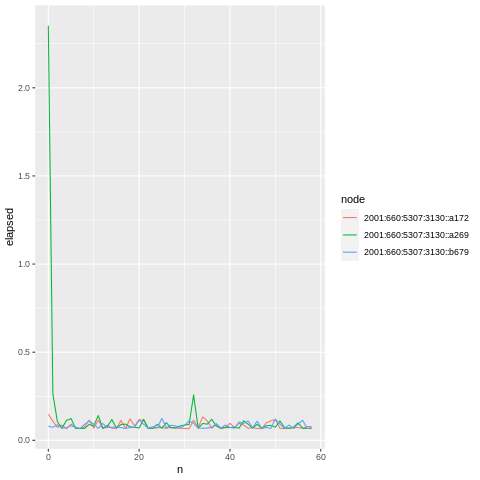

In [21]:
%%R -i df
library("ggplot2")
library("dplyr")
df %>% filter(ok == 1) %>%
ggplot(aes(x=n, y=elapsed, color=node)) + geom_line()

### Energy comsumption

Reading energy csv file.

In [22]:
%load_ext rpy2.ipython
import pandas
df = pandas.read_csv(output_dir + "/energy.csv")
df.head()

data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_16.oml
data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_17.oml
data/raw/2021-09-15/1ab70955-e471-4fff-9c27-199fecf0427f/277268/consumption/m3_18.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #4214 (got 1 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


timestamp         type   num         t_s    t_us     power  voltage  \
0     1.631695e+09  consumption     1  1631694723  684762  0.051176  3.26250   
1     1.631695e+09  consumption     2  1631694723  750581  0.051176  3.26250   
2     1.631695e+09  consumption     3  1631694723  816400  0.051176  3.26250   
3     1.631695e+09  consumption     4  1631694723  882219  0.051176  3.26250   
4     1.631695e+09  consumption     5  1631694723  948037  0.051176  3.26250   
...            ...          ...   ...         ...     ...       ...      ...   
4199  1.631695e+09  consumption  4200  1631694999  675862  0.168916  3.27500   
4200  1.631695e+09  consumption  4201  1631694999  741620  0.168183  3.27500   
4201  1.631695e+09  consumption  4202  1631694999  807408  0.166473  3.27500   
4202  1.631695e+09  consumption  4203  1631694999  873166  0.167695  3.27500   
4203  1.631695e+09  consumption  4204  1631694999  938924  0.165130  3.27625   

       current   node  
0     0.015697  m3_16  
1     0.015687  m3_16  
2     0.015687  m3_16  
3     0.015687  m3_16  
4     0.015687  m3_16  
...        ...    ...  
4199  0.051547  m3_18  
4200  0.051356  m3_18  
4201  0.050838  m3_18  
4202  0.051205  m3_18  
4203  0.050418  m3_18  

[12612 rows x 9 columns]

---
Once again, use R and ggplot to plot the mean power used by each sensor.

`summarise()` has grouped output by 't_s'. You can override using the `.groups` argument.


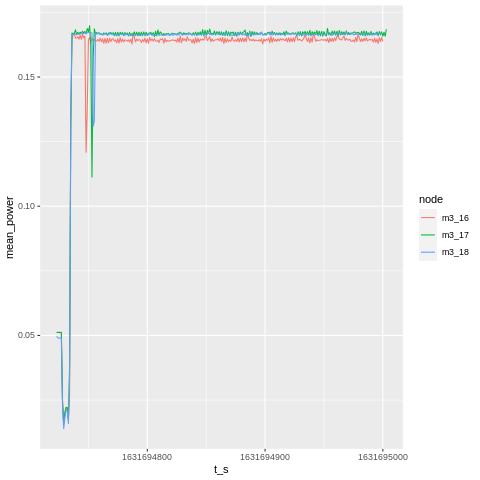

In [23]:
%%R -i df,duration
df %>% filter(t_s > max(t_s) - duration) %>% group_by(t_s, node) %>% summarize(mean_power = mean(power)) %>%  #filter last 5 min
ggplot(aes(x=t_s, y=mean_power, color=node)) + geom_line()

## Cleanup

Stop tunslip on IoT-LAB frontend

In [24]:
en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend) # kill running tunslip if any


PLAY [all] *********************************************************************

TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************
 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]
changed: [grenoble]


CommandResult(host='grenoble', task='pgrep -u "$(whoami)" tunslip6 | xargs -r kill', status='OK', payload={'changed': True, 'stdout': '', 'stderr': '', 'rc': 0, 'cmd': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', 'start': '2021-09-15 10:39:17.904794', 'end': '2021-09-15 10:39:17.924995', 'delta': '0:00:00.020201', 'msg': '', 'invocation': {'module_args': {'_raw_params': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', '_uses_shell': True, 'warn': True, 'stdin_add_newline': True, 'strip_empty_ends': True, 'argv': None, 'chdir': None, 'executable': None, 'creates': None, 'removes': None, 'stdin': None}}, 'stdout_lines': [], 'stderr_lines': [], '_ansible_no_log': False})

---
Destroy provider, free resources in testbed.

To re-use the reservation in multiple executions, destroy resources only if it's the last execution (controlled through the free_resources variables).

In [25]:
if free_resources:
    iotlab_provider.destroy()
    g5k_provider.destroy()

[    INFO] : Stopping experiment id (277268)
[    INFO] : Deleting monitoring profile: energy
[    INFO] : Reloading hackathon from grenoble
[    INFO] : Reloading hackathon from lille
[    INFO] : Reloading hackathon from luxembourg
[    INFO] : Reloading hackathon from lyon
[    INFO] : Reloading hackathon from nancy
[    INFO] : Reloading hackathon from nantes
[    INFO] : Reloading hackathon from rennes
[    INFO] : Reloading 1818591 from rennes
[    INFO] : Reloading hackathon from sophia
[    INFO] : Killing the job (rennes, 1818591)
